# <span style='color:blue'> Lending Club Case Study </span>
## Problem Statement
>The data given below contains information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.


In [311]:
#Uncomment Below lines when running in Google-Colab
#from google.colab import drive
#drive.mount('/content/drive')

## Import and Data read 

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import plotly.express as px
# Uncomment Below Line when running in Google Co-lab
#loanC = pd.read_csv('/content/drive/Othercomputers/My Laptop/GDrive/MS/Project/lending_club_casestudy/loan.csv',low_memory=False)
loanC= pd.read_csv("loan.csv",low_memory=False)
loanC.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [313]:
loanC.shape

(39717, 111)

### DataCleaning
### - Check whether the Member ID's are repeated
> 3 ways are implemented one of them can be uncommented


In [314]:
#(~(loanC.member_id.value_counts()==1)).sum() ## If Sum is 0 then there are no repeated values of the member_id
#loanC.member_id.value_counts() ## Alternatively the count 39717 Matches tghe total range in info
loanC.member_id.duplicated().sum()## Alternatively Look for Member-ID Duplication

0

### - Drop the Columns/Rows which have all NA's
        - Many Columns Dropped(111 Columns to 57 Columns)


In [315]:
LClb = loanC.dropna(axis=1,how='all')
LClb = LClb.dropna(axis=0,how='all')
LClb.shape

(39717, 57)

### - Check  All Columns not having NA


In [316]:
#LClb.loc[:,LClb.isna()]
LClb[~(LClb.isna().any(axis=1)==True)].shape

(14, 57)

### - Remove the Columns with only one Value (Which does not influence the results)
> . Use the lamda function for each column to find the size of value counts and check if there is only one value inthe value_counts

> Note : Columns with a one Valid value and NA is still treated as a single value columns

In [317]:
LClb = LClb.loc[:,list(map(lambda x : False if LClb[x].value_counts().size==1 else True , list(LClb)))] #remove single value columns
LClb.shape


(39717, 48)

### - Public recorded bankruptsies 
> . Replace NaN from this record to zero (Assume that those members are not bankrupt)
> . 




In [318]:
LClb.loc[(LClb.pub_rec_bankruptcies.isna()==True),"pub_rec_bankruptcies"] = 0
LClb.loc[(LClb.pub_rec_bankruptcies.isna()==True)]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies


In [319]:
LClb["pub_rec_bankruptcies"].value_counts()

0.0    38036
1.0     1674
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [320]:
LClb.shape

(39717, 48)

### - Study of the Correlation between various columns to check whether any columns can be removed.
> . Replace NaN from this record to zero (Assume that those members are not bankrupt)
> . 


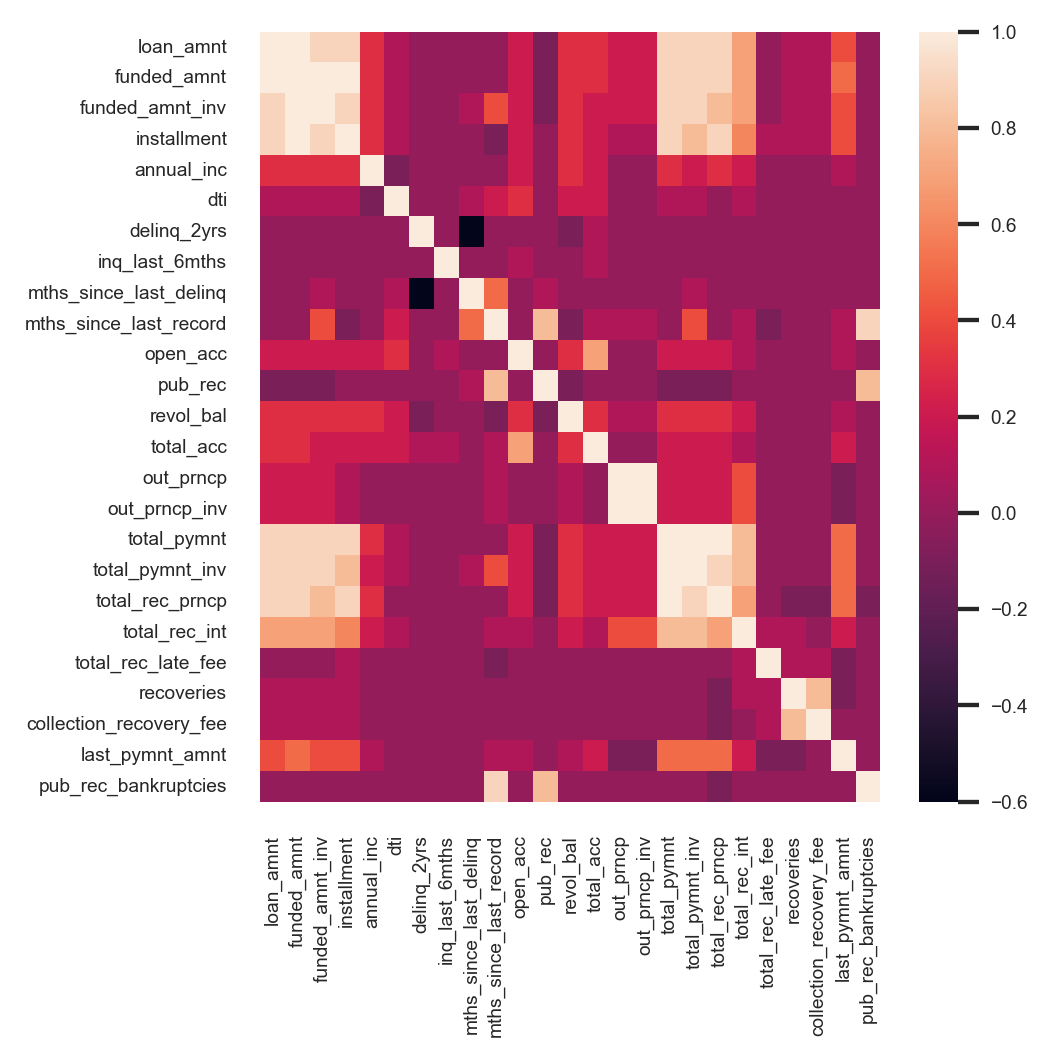

In [321]:
import plotly.express as px
from matplotlib.pyplot import figure
figure(figsize=(4,4), dpi=250)
LClbCor = LClb.iloc[:,2:].corr().round(1)
sb.set(font_scale=0.5)
plt.xticks(rotation=0)
#LClbCor.style.background_gradient(cmap='PuBu')
sb.heatmap(LClb.iloc[:,2:].corr().round(1),annot=False)
sb.set(font_scale=1)

### - Dropping Certain Colums which add least value in the Analysis

> - Unneccesary Columns 'desc','url'...etc
> - Drop Corrlelated Columns 

In [322]:
LClb.drop(columns = [ 'emp_title', 'url', 'desc', 'title'], inplace = True)
# Drop Correlated Columns 
LClb.drop(columns = [ 'funded_amnt', 'total_pymnt_inv', 'out_prncp_inv'], inplace = True)


### - Clenup Employee Experience (Employment Length)

> - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years as specified in "RejectStats" of "DataDictionary.xlsx"

In [323]:
LClb.emp_length.astype('str').apply(lambda x: x[0:2] if (x[0:3] == '10+') else x).value_counts()#.apply(lambda x: 0 if (x[0] == '<') else x[0]).value_counts()
LClb.emp_length.astype('str').value_counts()
# Experience Length capped to 10 and 0 
LClb.emp_length = LClb.emp_length.astype('str').apply(lambda x: x[0:2] if (x[0:3] == '10+') else x).apply(lambda x: 0 if (x[0] == '<') else x).replace(regex = 'years',value = '').replace(regex = 'year',value = '').replace(to_replace='nan',value='0').astype("int32")
LClb.emp_length.value_counts()

10    8879
0     5658
2     4388
3     4095
4     3436
5     3282
1     3240
6     2229
7     1773
8     1479
9     1258
Name: emp_length, dtype: int64

### - Remove % from Interest Rates (Post-Processed Interest rates)



In [324]:
LClb["int_rate_pp"] = LClb.int_rate.apply(lambda x:  x[:-1]).astype("float32")

In [325]:
LClb.loc[5].value_counts().size


30

In [326]:
LClb.describe()

,id,member_id,loan_amnt,funded_amnt_inv,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,out_prncp,total_pymnt,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,int_rate_pp
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,...,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000
mean,6.831319e+05,8.504636e+05,11219.443815,10397.448868,324.561922,4.838835,6.896893e+04,13.315130,0.146512,0.869200,...,51.227887,12153.596544,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.042501,12.020760
std,2.106941e+05,2.656783e+05,7456.670694,7128.450439,208.874874,3.605528,6.379377e+04,6.678594,0.491812,1.070219,...,375.172839,9042.040766,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.202603,3.724828
min,5.473400e+04,7.069900e+04,500.000000,0.000000,15.690000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.420000
25%,5.162210e+05,6.667800e+05,5500.000000,5000.000000,167.020000,2.000000,4.040400e+04,8.170000,0.000000,0.000000,...,0.000000,5576.930000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.000000,9.250000
50%,6.656650e+05,8.508120e+05,10000.000000,8975.000000,280.220000,4.000000,5.900000e+04,13.400000,0.000000,1.000000,...,0.000000,9899.640319,8000.000000,1348.910000,0.000000,0.000000,0.000000,546.140000,0.000000,11.860000
75%,8.377550e+05,1.047339e+06,15000.000000,14400.000000,430.780000,9.000000,8.230000e+04,18.600000,0.000000,1.000000,...,0.000000,16534.433040,13653.260000,2833.400000,0.000000,0.000000,0.000000,3293.160000,0.000000,14.590000
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,1305.190000,10.000000,6.000000e+06,29.990000,11.000000,8.000000,...,6311.470000,58563.679930,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,2.000000,24.590000


In [327]:
LClb.mths_since_last_delinq.describe()
LClb.verification_status.value_counts()
LClb.mths_since_last_record.describe()
LClb.loan_status.value_counts()
LClb.dti.describe()
LClb.pub_rec.value_counts()
LClb.purpose.value_counts()
LClb.delinq_2yrs.value_counts()  #The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
#A delinquency is a late payment.The consequences of a delinquency can be severe when it comes to your credit score.
LClb.mths_since_last_record.value_counts()

0.0      670
104.0     61
89.0      60
113.0     59
111.0     57
        ... 
19.0       1
20.0       1
120.0      1
129.0      1
5.0        1
Name: mths_since_last_record, Length: 111, dtype: int64

In [328]:
LClb.emp_length.isna().sum()


0

### - Converting the Ordinal Variable Grade/Subgrade to Numeric Variable

> Here we create a Numeric variable from an Ordinal Variable sub_grade to study the distribution and correlation
> A new column called sgradenum is created

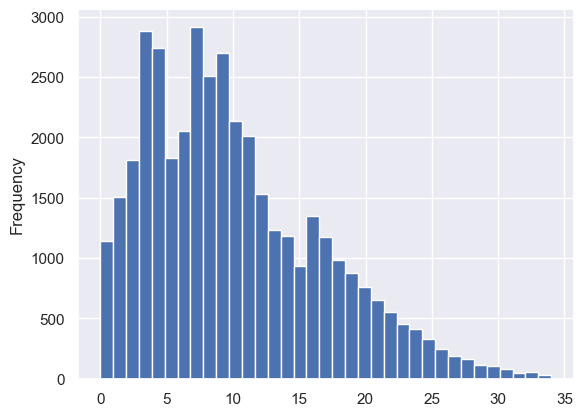

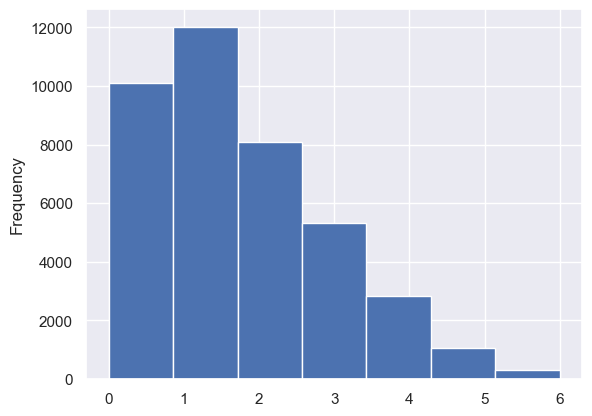

In [329]:
import numpy as np
LClb['sgradenum']=LClb['sub_grade'].replace(LClb.sub_grade.astype('str').sort_values().unique(),np.array(range(0,35)),inplace=False)
LClb.sgradenum.plot.hist(bins=35)
plt.show()
LClb['gradenum']=LClb['grade'].replace(LClb.grade.astype('str').sort_values().unique(),np.array(range(0,7)),inplace=False)
LClb.gradenum.plot.hist(bins=7)
plt.show()

# Exploratory Data Analysis


## Univariate and Segmented Univariate Analysis

### - Frequency Analysis of the loan Amount

<AxesSubplot:ylabel='loan_amnt'>

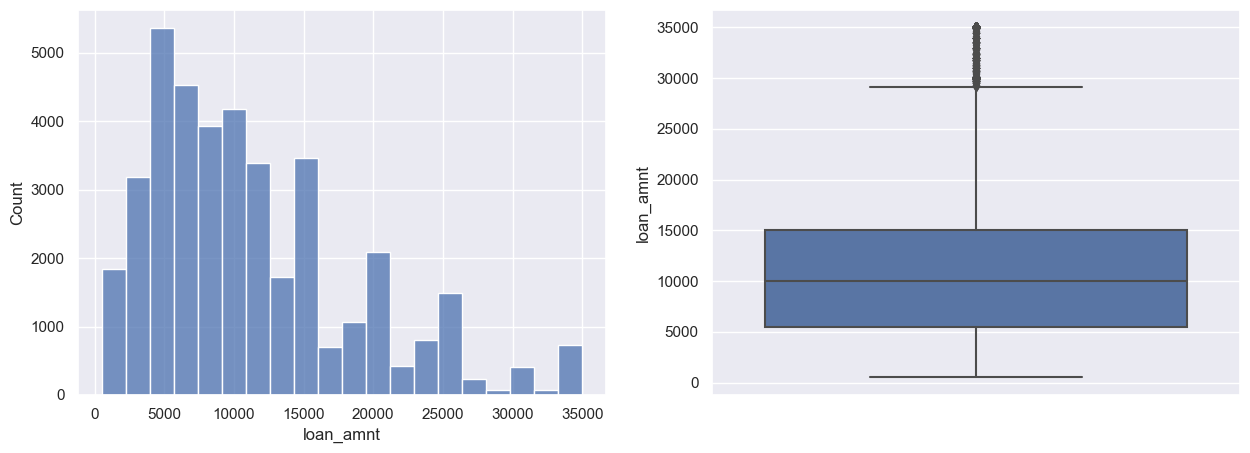

In [330]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sb.histplot(LClb.loan_amnt,ax=axes[0],bins=20)
sb.boxplot(ax=axes[1],x=None,y=LClb.loan_amnt)

### - Rank-Frequency plot for Debt-to-income ratio


<AxesSubplot:ylabel='dti'>

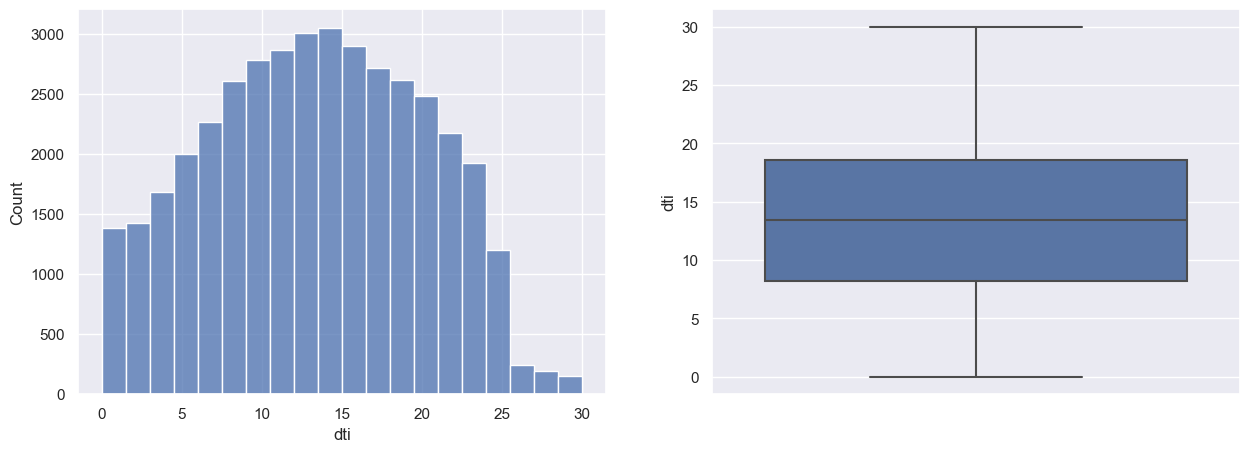

In [331]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sb.histplot(LClb.dti,ax=axes[0],bins=20)
sb.boxplot(ax=axes[1],x=None,y=LClb.dti)

### - Rank-Frequency for empl-length


<AxesSubplot:ylabel='emp_length'>

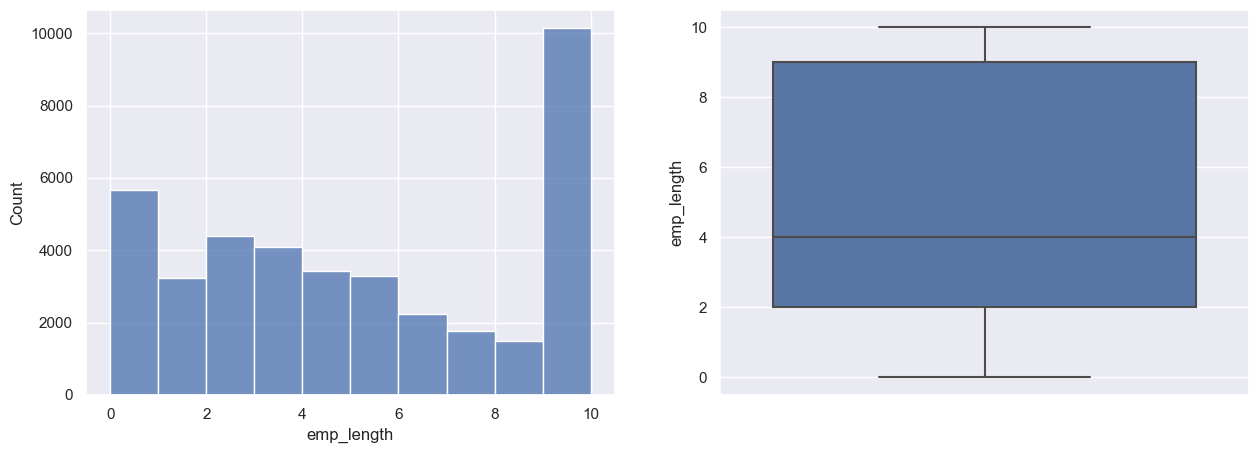

In [332]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sb.histplot(LClb.emp_length,ax=axes[0],bins=10)
sb.boxplot(ax=axes[1],x=None,y=LClb.emp_length)


### - Rank-Frequency for grades and sub-grades


<AxesSubplot:xlabel='sub_grade', ylabel='Count'>

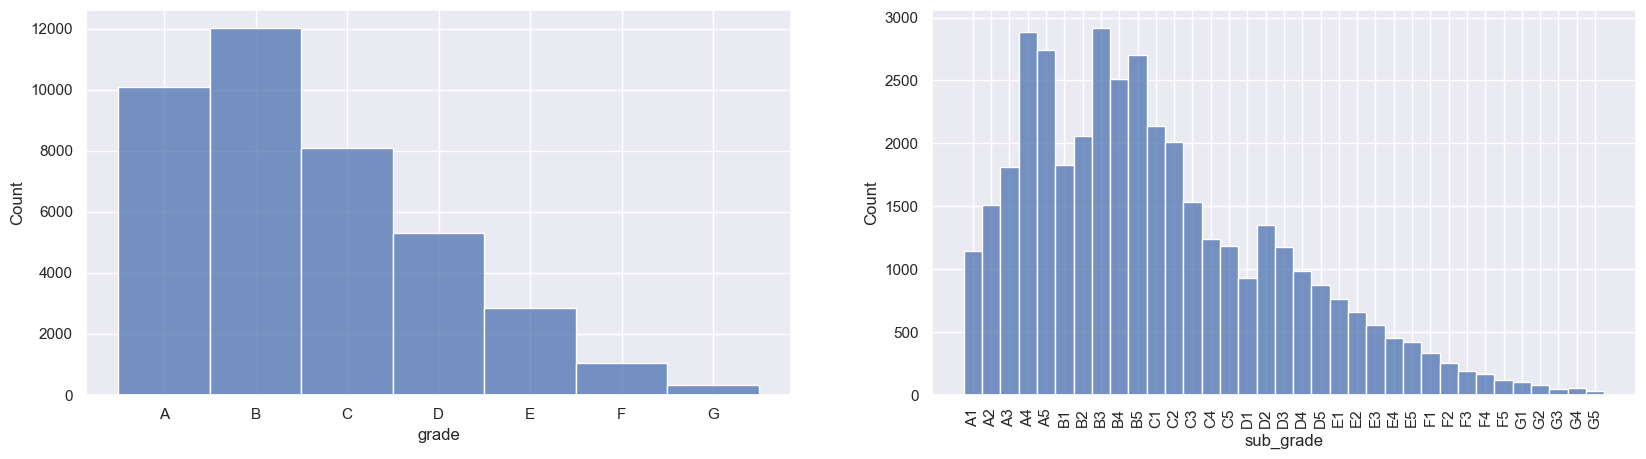

In [333]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.xticks(rotation=90)
sb.histplot(LClb.grade.sort_values(),ax=axes[0],bins=10)
sb.histplot(LClb.sub_grade.sort_values(),ax=axes[1],bins=10)


### - Rank-Frequency for Interest rates


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='int_rate'>

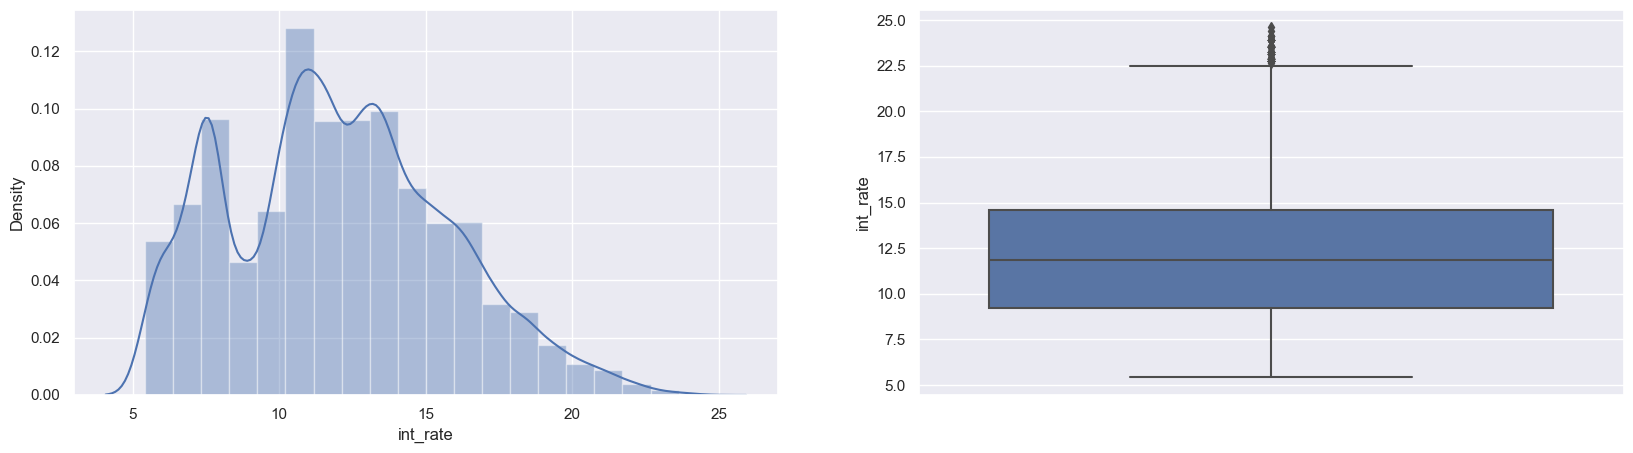

In [334]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sb.distplot(LClb.int_rate.apply(lambda x:  x[:-1]).astype("float32"),ax=axes[0],bins=20)
#sb.histplot(LClb.grade.sort_values(),ax=axes[1],bins=20)
sb.boxplot(ax=axes[1],x=None,y=LClb.int_rate.apply(lambda x:  x[:-1]).astype("float32"))


In [335]:
LClb.delinq_2yrs.value_counts()

0     35405
1      3303
2       687
3       220
4        62
5        22
6        10
7         4
8         2
9         1
11        1
Name: delinq_2yrs, dtype: int64

In [336]:
LClb[LClb.annual_inc>0.15e06].annual_inc.value_counts().sum()

1551

In [337]:
LClb.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

In [338]:
df = sb.load_dataset('tips')  
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## BiVariate Analysis

In [339]:
LClb.head()

,id,member_id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,pub_rec_bankruptcies,int_rate_pp,sgradenum,gradenum
0,1077501,1296599,5000,4975.0,36 months,10.65%,162.87,B,B2,10,...,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,10.65,6,1
1,1077430,1314167,2500,2500.0,60 months,15.27%,59.83,C,C4,0,...,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,15.27,13,2
2,1077175,1313524,2400,2400.0,36 months,15.96%,84.33,C,C5,10,...,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,15.96,14,2
3,1076863,1277178,10000,10000.0,36 months,13.49%,339.31,C,C1,10,...,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,13.49,10,2
4,1075358,1311748,3000,3000.0,60 months,12.69%,67.79,B,B5,1,...,0.00,0.00,May-16,67.79,Jun-16,May-16,0.0,12.69,9,1


In [340]:
LClb.purpose.value_counts()

debt_consolidation    18641
credit_card            5130
other                  3993
home_improvement       2976
major_purchase         2187
small_business         1828
car                    1549
wedding                 947
medical                 693
moving                  583
vacation                381
house                   381
educational             325
renewable_energy        103
Name: purpose, dtype: int64

### -Relationship between the Grade and the Loan Status
> - Find the relationship between two catorical variables Grade and loan status
> - Find the relationship between two catorical variables Sub-Grade and loan status
> - Find the Prabability of Default(Charged Off) for each Grades/Sub-Grades  

In [341]:
LC1b_GradevsLS = LClb.filter(items =["grade","loan_status"] )
TblGrdVersusLS = pd.crosstab(LC1b_GradevsLS.loan_status, LC1b_GradevsLS["grade"], margins=True,     values=LC1b_GradevsLS["loan_status"], aggfunc='count').round(2)
TblGrdVersusLS.loc["Prob_Def",:] = TblGrdVersusLS.loc["Charged Off",:]/TblGrdVersusLS.loc["All",:]
TblGrdVersusLS.head()

grade,A,B,C,D,E,F,G,All
loan_status,,,,,,,,
Charged Off,602.000000,1425.000000,1347.000000,1118.000000,715.000000,319.000000,101.00000,5627.000000
Current,40.000000,345.000000,264.000000,222.000000,179.000000,73.000000,17.00000,1140.000000
Fully Paid,9443.000000,10250.000000,6487.000000,3967.000000,1948.000000,657.000000,198.00000,32950.000000
All,10085.000000,12020.000000,8098.000000,5307.000000,2842.000000,1049.000000,316.00000,39717.000000
Prob_Def,0.059693,0.118552,0.166337,0.210665,0.251583,0.304099,0.31962,0.141677


<function matplotlib.pyplot.show(close=None, block=None)>

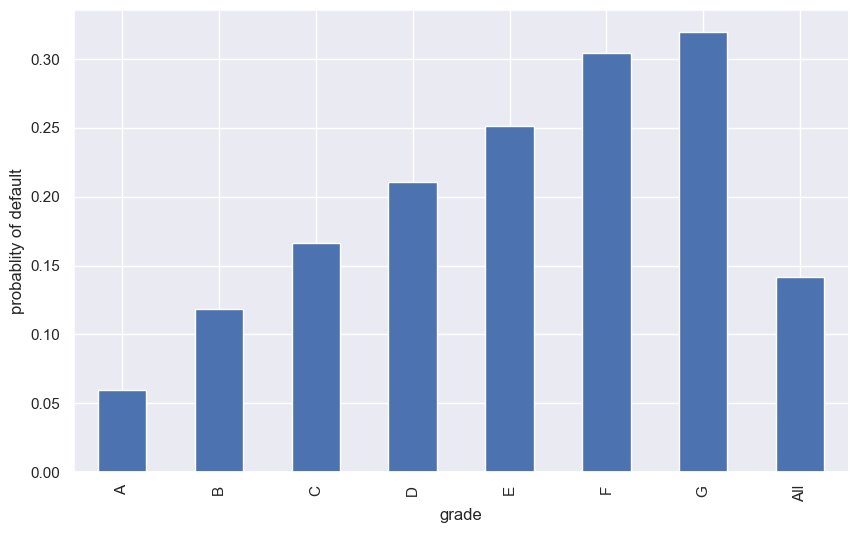

In [342]:
TblGrdVersusLS.iloc[4,:].plot.bar(figsize=[10,6])
plt.ylabel("probablity of default")
plt.show

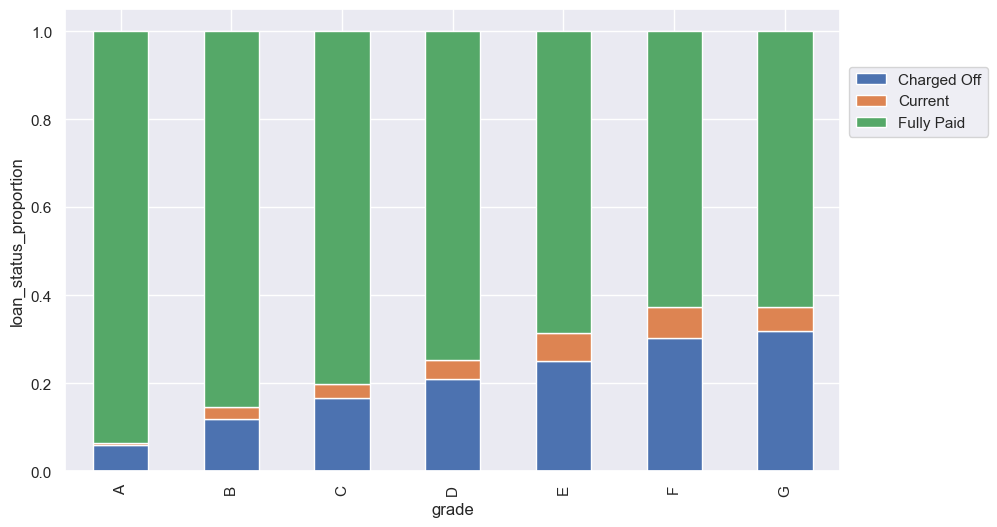

In [343]:
#TblGrdVersusLS.loc["Prob_Def",:].plot(kind="bar", stacked="True", figsize=[10,6])
#}plt.show()
TblGrdVersusLS_perc = TblGrdVersusLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
TblGrdVersusLS_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.ylabel("loan_status_proportion")
plt.legend(bbox_to_anchor=(1.2, 0.8),loc='right')
plt.show()

In [344]:
LC1b_SGradevsLS = LClb.filter(items =["sub_grade","loan_status"] )
TblSGrdVersusLS = pd.crosstab(LC1b_SGradevsLS.loan_status, LC1b_SGradevsLS["sub_grade"], margins=True,     values=LC1b_SGradevsLS["loan_status"], aggfunc='count').round(2)
TblSGrdVersusLS.head()

sub_grade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,...,F2,F3,F4,F5,G1,G2,G3,G4,G5,All
loan_status,,,,,,,,,,,,,,,,,,,,,
Charged Off,30.0,74.0,103.0,178.0,217.0,171.0,228.0,341.0,329.0,356.0,...,70.0,51.0,53.0,54.0,31.0,28.0,19.0,13.0,10.0,5627
Current,NaN,NaN,NaN,13.0,27.0,33.0,56.0,92.0,75.0,89.0,...,16.0,11.0,17.0,5.0,10.0,1.0,3.0,2.0,1.0,1140
Fully Paid,1109.0,1434.0,1707.0,2695.0,2498.0,1626.0,1773.0,2484.0,2108.0,2259.0,...,163.0,123.0,98.0,59.0,63.0,49.0,26.0,41.0,19.0,32950
All,1139.0,1508.0,1810.0,2886.0,2742.0,1830.0,2057.0,2917.0,2512.0,2704.0,...,249.0,185.0,168.0,118.0,104.0,78.0,48.0,56.0,30.0,39717


In [345]:

LC1b_SGradevsLS = LClb.filter(items =["sub_grade","grade","loan_status"] )
#TblSGrdVersusLS = pd.pivot_table(data=LC1b_SGradevsLS, values="loan_status", columns="sub_grade", aggfunc='count')
TblSGrdVersusLS.loc["Prob_Def",:] = TblSGrdVersusLS.loc["Charged Off",:]/TblSGrdVersusLS.loc["All",:]
TblSGrdVersusLS.head()


sub_grade,A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,...,F2,F3,F4,F5,G1,G2,G3,G4,G5,All
loan_status,,,,,,,,,,,,,,,,,,,,,
Charged Off,30.000000,74.000000,103.000000,178.000000,217.000000,171.000000,228.000000,341.000000,329.000000,356.000000,...,70.000000,51.000000,53.000000,54.000000,31.000000,28.000000,19.000000,13.000000,10.000000,5627.000000
Current,NaN,NaN,NaN,13.000000,27.000000,33.000000,56.000000,92.000000,75.000000,89.000000,...,16.000000,11.000000,17.000000,5.000000,10.000000,1.000000,3.000000,2.000000,1.000000,1140.000000
Fully Paid,1109.000000,1434.000000,1707.000000,2695.000000,2498.000000,1626.000000,1773.000000,2484.000000,2108.000000,2259.000000,...,163.000000,123.000000,98.000000,59.000000,63.000000,49.000000,26.000000,41.000000,19.000000,32950.000000
All,1139.000000,1508.000000,1810.000000,2886.000000,2742.000000,1830.000000,2057.000000,2917.000000,2512.000000,2704.000000,...,249.000000,185.000000,168.000000,118.000000,104.000000,78.000000,48.000000,56.000000,30.000000,39717.000000
Prob_Def,0.026339,0.049072,0.056906,0.061677,0.079139,0.093443,0.110841,0.116901,0.130971,0.131657,...,0.281124,0.275676,0.315476,0.457627,0.298077,0.358974,0.395833,0.232143,0.333333,0.141677


<function matplotlib.pyplot.show(close=None, block=None)>

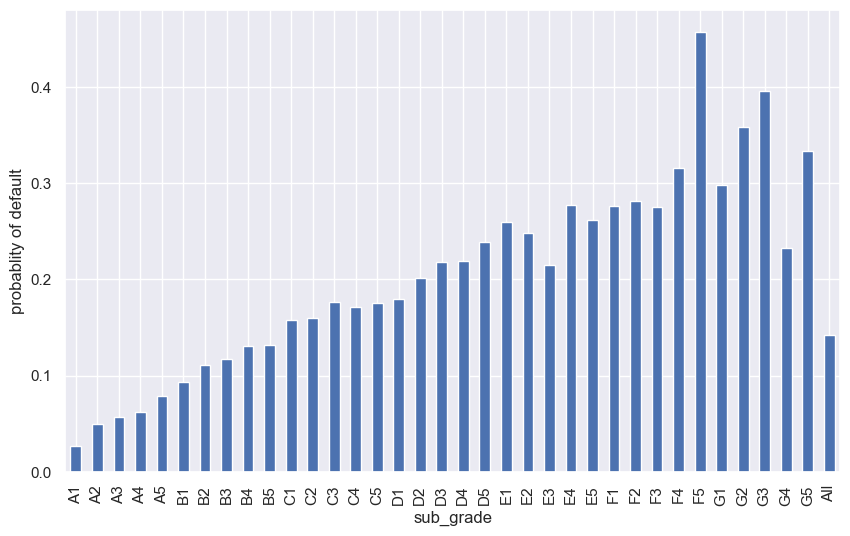

In [346]:
#plt.scatter(TblSGrdVersusLS.sub_grade.unique, TblSGrdVersusLS.loc["Prob_Def",:])
TblSGrdVersusLS.iloc[4,:].plot.bar(figsize=[10,6])
plt.ylabel("probablity of default")

plt.show

> Subgradewise Probability of Default

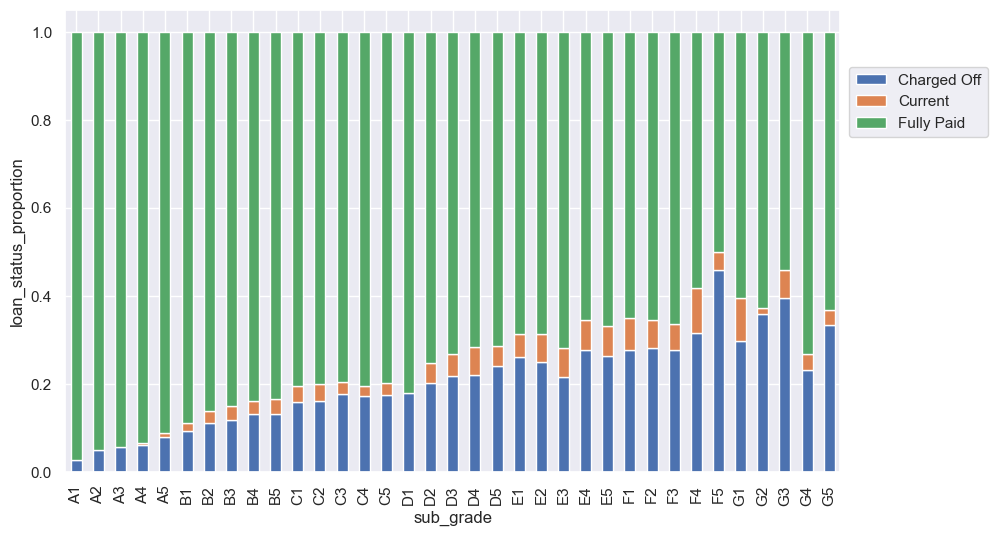

In [347]:
#blSGrdVersusLS.transpose().plot(kind="bar", stacked="True", figsize=[10,6])
TblSGrdVersusLS_perc = TblSGrdVersusLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
TblSGrdVersusLS_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.ylabel("loan_status_proportion")
plt.legend(bbox_to_anchor=(1.2, 0.8),loc='right')
plt.show()


### - Is there any Relationship between purpose of loan versus the loan defaults
> - Find the relationship between two catorical variables Grade and loan status
> - Find the relationship between two catorical variables Sub-Grade and loan status
> - Find the Prabability of Default(Charged Off) For each Grades/Sub-Grades

In [348]:
LClb.purpose.value_counts(normalize=True)*100


debt_consolidation    46.934562
credit_card           12.916383
other                 10.053629
home_improvement       7.493013
major_purchase         5.506458
small_business         4.602563
car                    3.900093
wedding                2.384369
medical                1.744845
moving                 1.467885
vacation               0.959287
house                  0.959287
educational            0.818289
renewable_energy       0.259335
Name: purpose, dtype: float64

In [349]:
TblPurVersusLS = pd.crosstab(LClb.loan_status, LClb["purpose"], margins=True,     values=LClb["loan_status"], aggfunc='count').round(2)
TblPurVersusLS.loc["Prob_Def",:] = TblPurVersusLS.loc["Charged Off",:]/TblPurVersusLS.loc["All",:]
TblPurVersusLS.head()


purpose,car,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,All
loan_status,,,,,,,,,,,,,,,
Charged Off,160.000000,542.000000,2767.000000,56.000000,347.000000,59.000000,222.000000,106.000000,92.000000,633.000000,19.000000,475.000000,53.000000,96.000000,5627.000000
Current,50.000000,103.000000,586.000000,NaN,101.000000,14.000000,37.000000,12.000000,7.000000,128.000000,1.000000,74.000000,6.000000,21.000000,1140.000000
Fully Paid,1339.000000,4485.000000,15288.000000,269.000000,2528.000000,308.000000,1928.000000,575.000000,484.000000,3232.000000,83.000000,1279.000000,322.000000,830.000000,32950.000000
All,1549.000000,5130.000000,18641.000000,325.000000,2976.000000,381.000000,2187.000000,693.000000,583.000000,3993.000000,103.000000,1828.000000,381.000000,947.000000,39717.000000
Prob_Def,0.103292,0.105653,0.148436,0.172308,0.116599,0.154856,0.101509,0.152958,0.157804,0.158527,0.184466,0.259847,0.139108,0.101373,0.141677


Text(0.5, 0, 'probablity of default')

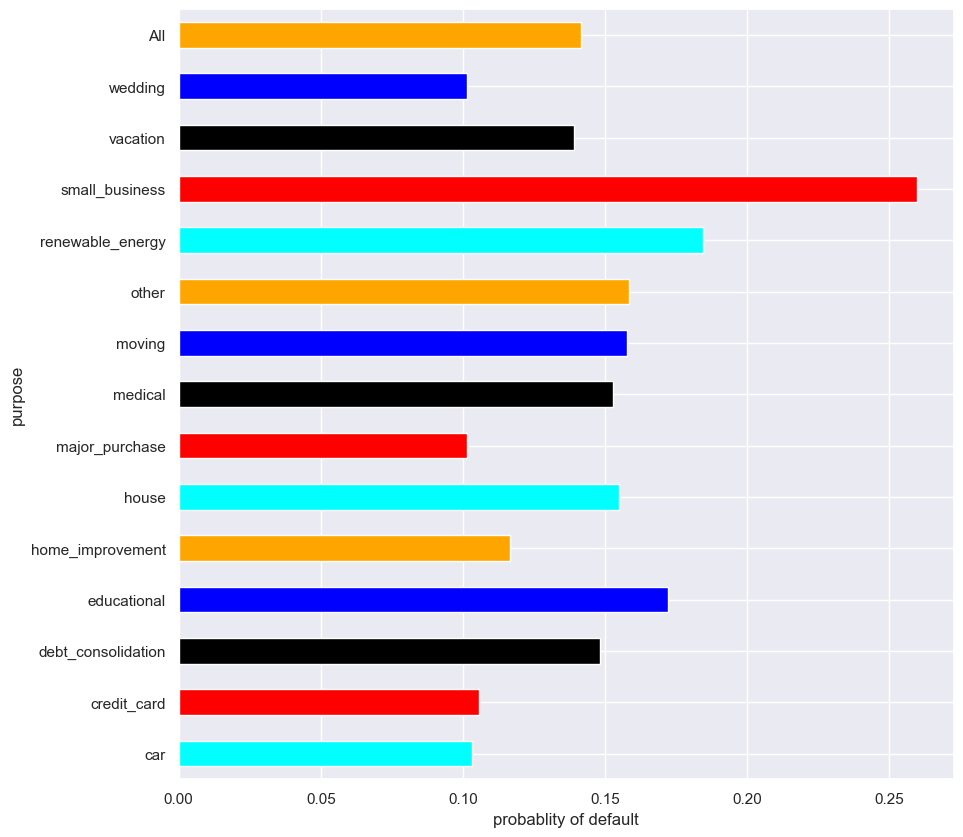

In [350]:
c = ['cyan', 'red', 'black', 'blue', 'orange']
TblPurVersusLS.iloc[4,:].plot.barh(figsize=[10,10],color=c)
plt.show
plt.xlabel("probablity of default")
#sb.barplot(x=TblPurVersusLS.iloc[4],y=TblPurVersusLS.iloc[4,:])

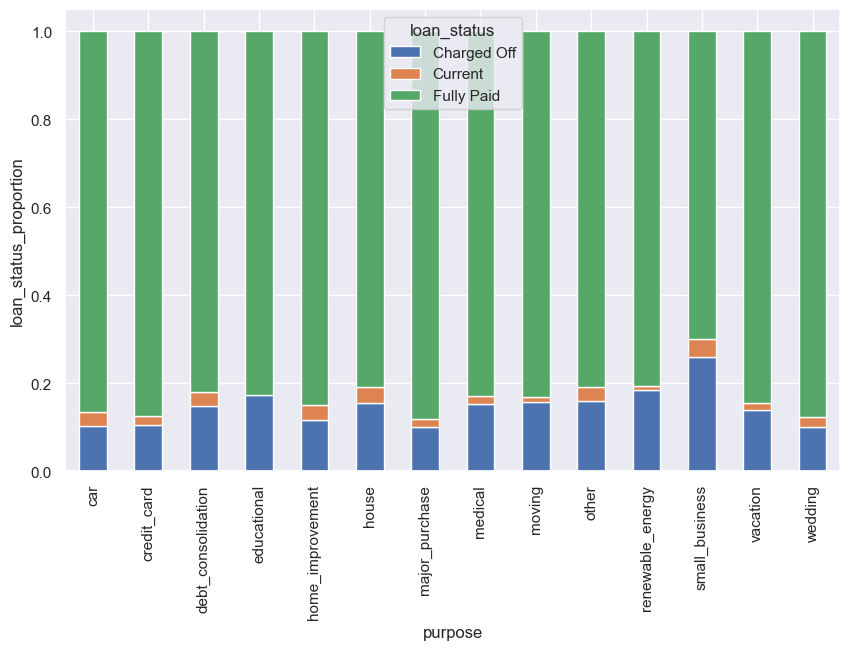

In [351]:
TblPurVersusLS_perc = TblPurVersusLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
TblPurVersusLS_perc.plot(kind="bar", stacked="True", figsize=[10,6])
plt.ylabel("loan_status_proportion")
plt.show()

### - Is there any Relationship between purpose of loan versus the mean interest rates
> - Find the relationship between two catorical variables Grade and loan status
> - Find the relationship between two catorical variables Sub-Grade and loan status
> - Find the Prabability of Default(Charged Off) For each Grades/Sub-Grades

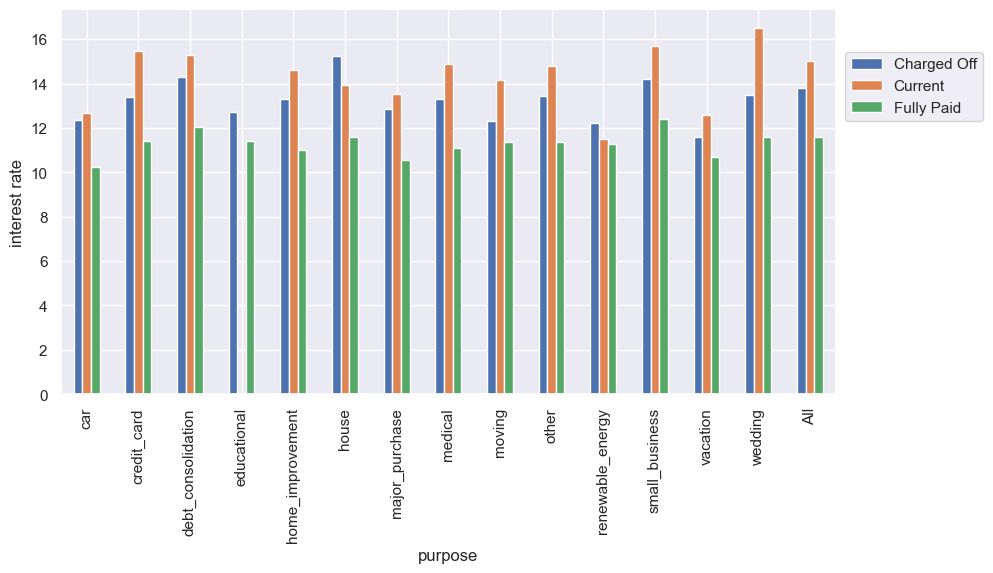

In [352]:
LClb.int_rate.apply(lambda x:  x[:-1]).astype('float')
TblPurIntrate = pd.crosstab(LClb.int_rate.apply(lambda x:  x[:-1]).astype('float'), LClb["purpose"], margins=True,     values=LClb.int_rate.apply(lambda x:  x[:-1]).astype('float'), aggfunc='mean').round(2)
#TblPurIntrate.loc["Prob_Def",:] = TblPurVersusLS.loc["Charged Off",:]/TblSGrdVersusLS.loc["All",:]
#TblPurIntrate.head()
TblPurIntrate = pd.crosstab(LClb.loan_status, LClb["purpose"], margins=True,     values=LClb.int_rate.apply(lambda x:  x[:-1]).astype('float'), aggfunc='mean').round(2)
TblPurIntrate.iloc[:-1,:].transpose().plot.bar(figsize=[10,5])
plt.ylabel("interest rate")
plt.legend(bbox_to_anchor=(1.2, 0.8),loc='right')

### - Spread of  Annual Income among various Loan_Status Categories (Seen across "Purpose" category)
> - Find the relationship between two Numerical variable Annual income with catorical Loan Status and Purpose


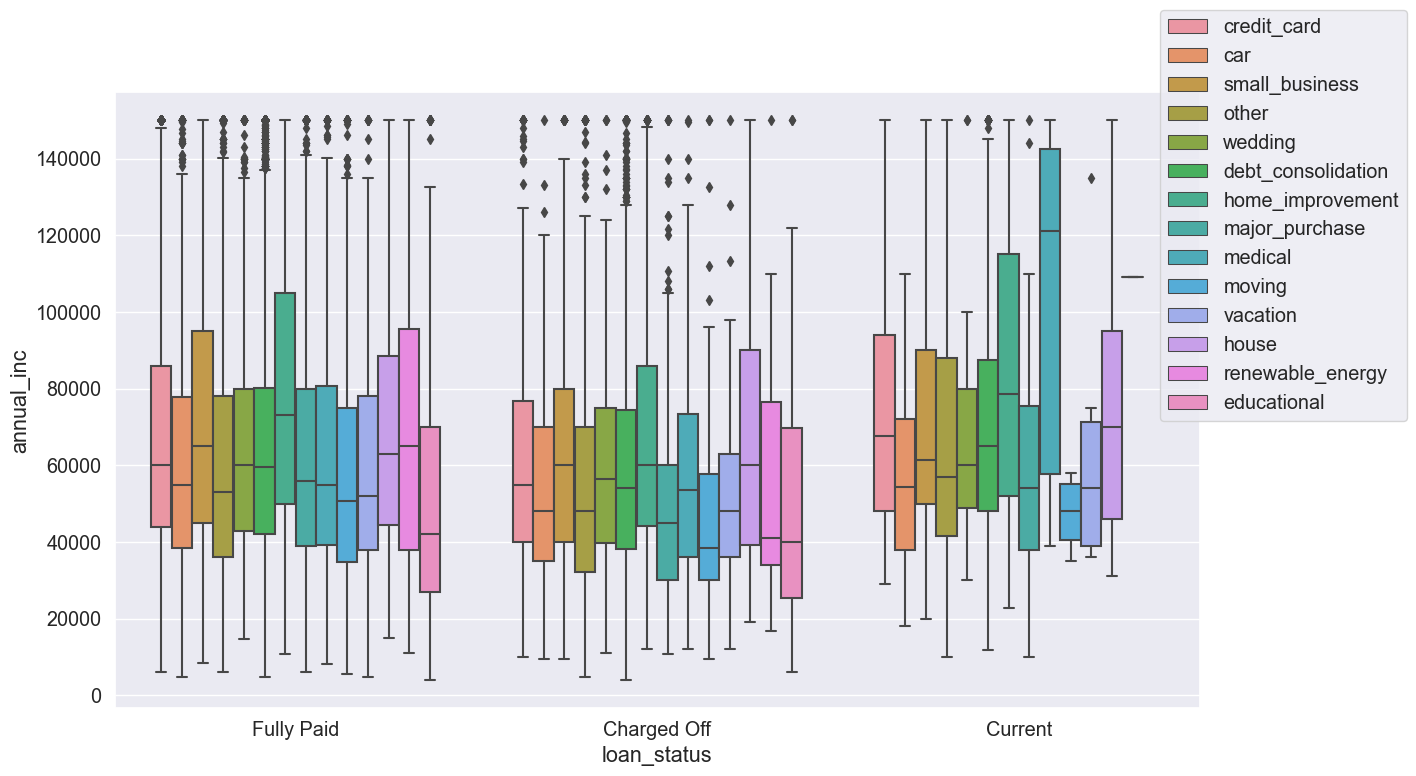

In [353]:

## Data Cleaning for Annual_inc
LClb_mod = LClb;
LClb_mod[LClb_mod.annual_inc>0.15e06].annual_inc.value_counts().sum()
LClb_mod.loc[LClb_mod.annual_inc>0.15e06,"annual_inc"] = 0.15e06
#
sb.set(font_scale=1.3)
plt.figure(figsize =(14, 8))
sb.boxplot(x='loan_status', y='annual_inc', data=LClb_mod,hue='purpose')
plt.show
plt.legend(bbox_to_anchor=(1.2, 0.8),loc='right')
#plt.title('Graph')
   

<function matplotlib.pyplot.show(close=None, block=None)>

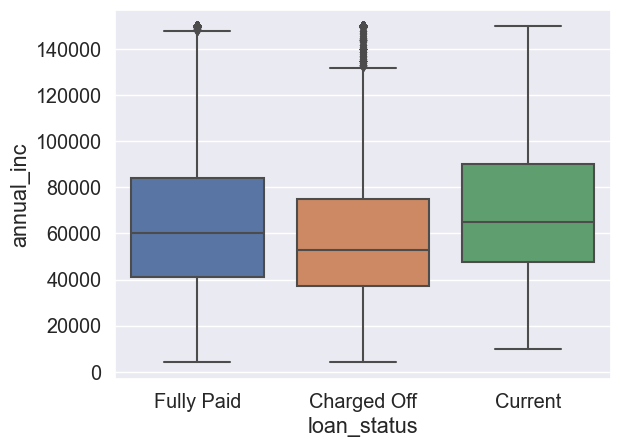

In [354]:
sb.boxplot(x='loan_status', y='annual_inc', data=LClb_mod)
plt.show


### - Is there any Relationship between Employment Length versus the Default


In [355]:
#LC1b_ELvsLS = LClb.filter(items =["emp_length","loan_status"] )
Tbl_ELvsLS = pd.crosstab(LClb.loan_status, LClb["emp_length"], margins=True,     values=LClb["loan_status"], aggfunc='count').round(2)
Tbl_ELvsLS.loc["Prob_Def",:] = Tbl_ELvsLS.loc["Charged Off",:]/Tbl_ELvsLS.loc["All",:]
Tbl_ELvsLS = Tbl_ELvsLS.fillna(0)
Tbl_ELvsLS.head()

emp_length,0,1,2,3,4,5,6,7,8,9,10,All
loan_status,,,,,,,,,,,,
Charged Off,867.000000,456.000000,567.000000,555.000000,462.000000,458.000000,307.00000,263.000000,203.000000,158.000000,1331.000000,5627.000000
Current,117.000000,71.000000,97.000000,83.000000,94.000000,88.000000,61.00000,62.000000,44.000000,32.000000,391.000000,1140.000000
Fully Paid,4674.000000,2713.000000,3724.000000,3457.000000,2880.000000,2736.000000,1861.00000,1448.000000,1232.000000,1068.000000,7157.000000,32950.000000
All,5658.000000,3240.000000,4388.000000,4095.000000,3436.000000,3282.000000,2229.00000,1773.000000,1479.000000,1258.000000,8879.000000,39717.000000
Prob_Def,0.153234,0.140741,0.129216,0.135531,0.134459,0.139549,0.13773,0.148336,0.137255,0.125596,0.149904,0.141677


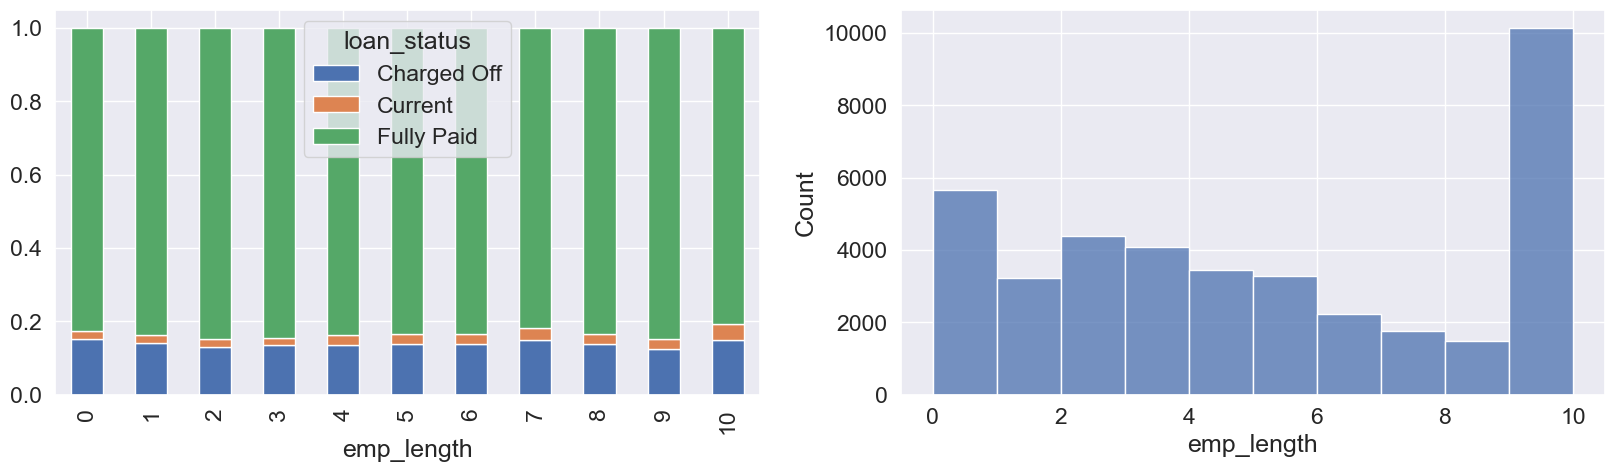

In [356]:
sb.set(font_scale=1.5)
Tbl_ELvsLS_perc = Tbl_ELvsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_ELvsLS_perc.plot(kind="bar", stacked="True",ax=axes[0])
sb.histplot(LClb.emp_length,bins=10,ax=axes[1])
plt.show()

### - Is there any Relationship between Deliquency versus the Default


In [357]:
Tbl_DelvsLS = pd.crosstab(LClb.loan_status, LClb["delinq_2yrs"], margins=True,     values=LClb["loan_status"], aggfunc='count').round(2)
Tbl_DelvsLS.loc["Prob_Def",:] = Tbl_DelvsLS.loc["Charged Off",:]/Tbl_DelvsLS.loc["All",:]
Tbl_DelvsLS.loc["Prob_Def",:]  = Tbl_DelvsLS.loc["Prob_Def",:].round(2)
Tbl_DelvsLS = Tbl_DelvsLS.fillna(0)
Tbl_DelvsLS.head().round(2)

delinq_2yrs,0,1,2,3,4,5,6,7,8,9,11,All
loan_status,,,,,,,,,,,,
Charged Off,4936.00,507.00,130.00,35.00,13.00,3.00,1.0,1.00,1.0,0.0,0.0,5627.00
Current,1019.00,96.00,14.00,8.00,2.00,1.00,0.0,0.00,0.0,0.0,0.0,1140.00
Fully Paid,29450.00,2700.00,543.00,177.00,47.00,18.00,9.0,3.00,1.0,1.0,1.0,32950.00
All,35405.00,3303.00,687.00,220.00,62.00,22.00,10.0,4.00,2.0,1.0,1.0,39717.00
Prob_Def,0.14,0.15,0.19,0.16,0.21,0.14,0.1,0.25,0.5,0.0,0.0,0.14


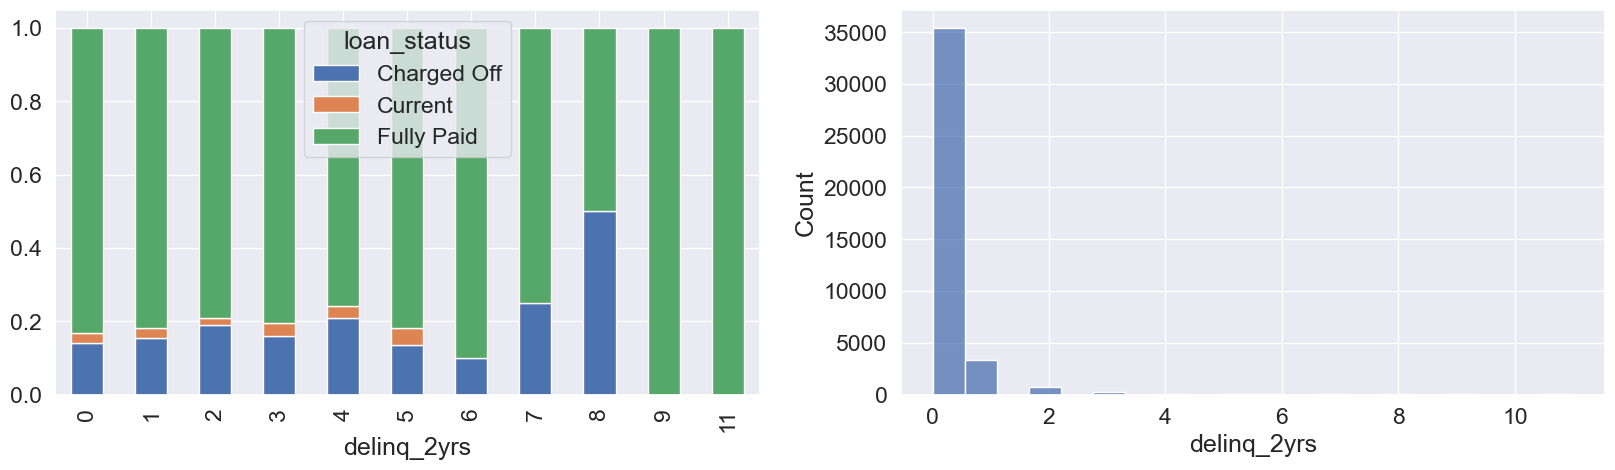

In [358]:
sb.set(font_scale=1.5)
Tbl_DelvsLS_perc = Tbl_DelvsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_DelvsLS_perc.plot(ax=axes[0],kind="bar", stacked="True")

sb.histplot(LClb.delinq_2yrs,ax=axes[1],bins=20)
plt.show()

### - Influence of Home ownership status with the loan status

In [359]:
Tbl_HOVsLS= pd.crosstab(LClb.loan_status, LClb["home_ownership"], margins=True,     values=LClb["loan_status"], aggfunc='count').round(2)
Tbl_HOVsLS.loc["Prob_Def",:] = Tbl_HOVsLS.loc["Charged Off",:]/Tbl_HOVsLS.loc["All",:]
Tbl_HOVsLS = Tbl_HOVsLS.fillna(0).round(2)
Tbl_HOVsLS

home_ownership,MORTGAGE,NONE,OTHER,OWN,RENT,All
loan_status,,,,,,
Charged Off,2327.00,0.0,18.00,443.00,2839.00,5627.00
Current,638.00,0.0,0.00,83.00,419.00,1140.00
Fully Paid,14694.00,3.0,80.00,2532.00,15641.00,32950.00
All,17659.00,3.0,98.00,3058.00,18899.00,39717.00
Prob_Def,0.13,0.0,0.18,0.14,0.15,0.14


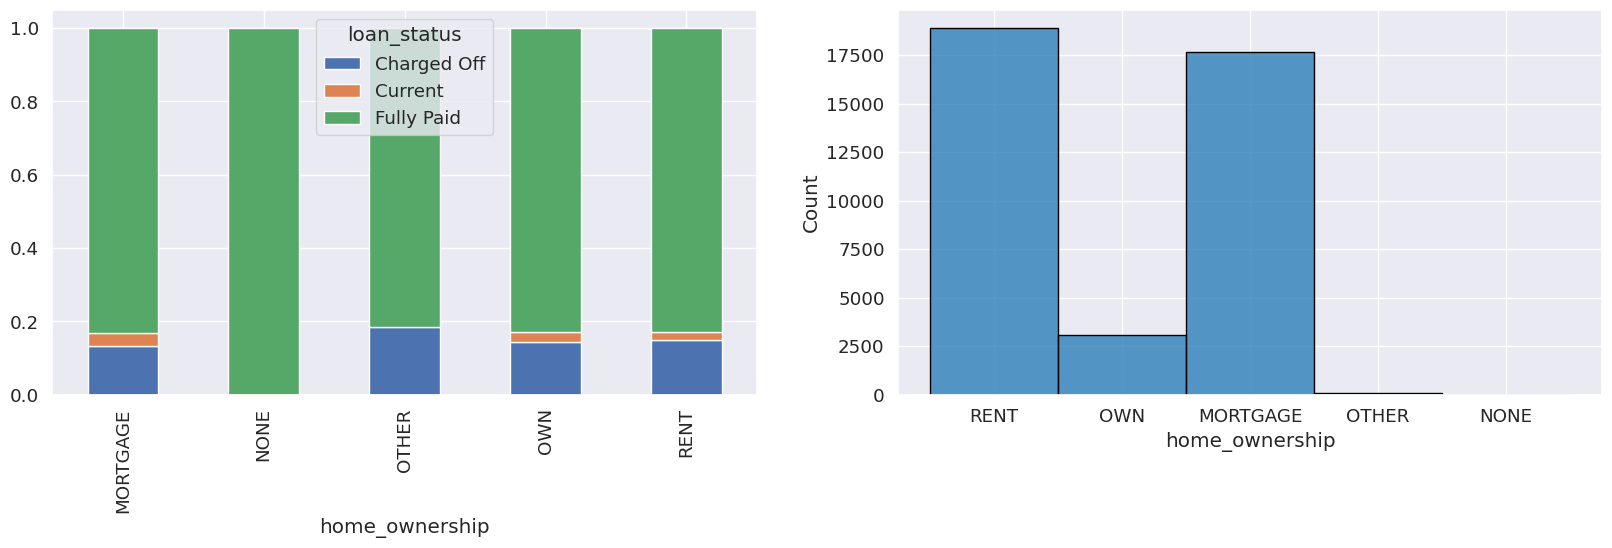

In [360]:
sb.set(font_scale=1.2)
Tbl_HOVsLS_perc = Tbl_HOVsLS.transpose().iloc[:-1,:-2].apply(lambda x: x/x.sum(), axis=1)
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
Tbl_HOVsLS_perc.plot(ax=axes[0],kind="bar", stacked="True")
sb.reset_defaults()
sb.histplot(LClb.home_ownership,ax=axes[1],bins=20)
plt.show()

# RISK ASSESSMENT

### FICO Score 

![image.png](attachment:image.png)

https://www.myfico.com/credit-education/whats-in-your-credit-score

![image.png](attachment:image.png)


https://www.forbes.com/advisor/credit-score/what-is-vantagescore/
> https://towardsdatascience.com/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03

In [361]:
#LClb[].loan_status.value_counts(normalize=True)


### -Correlation of All Numeric Variables with the Loan_Default 


In [362]:
from pandas.core.indexes.interval import annotations
import plotly.express as px
#fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
#fig.show()
LClb["loan_defaulted"] =  LClb.loan_status.apply(lambda x: 1 if (x=="Charged Off") else 0 )
LoanDfltCorr = LClb.corrwith(LClb.loan_defaulted)
sb.set(font_scale=1.5)
#plt.figure(figsize=(20, 10))
#plt.xticks(rotation=90)
#plt.ylabel("Correlation with loan_default")
#sb.lineplot(data=LoanDfltCorr)
#plt.show
fig = px.area(data_frame=LoanDfltCorr,title='Correlation with loan_default')
fig.show()


In [363]:
sb.reset_defaults

<function seaborn.rcmod.reset_defaults()>